In [1]:
import numpy as np
import matplotlib
#allow for latex markup in matplotlib figures
matplotlib.rcParams['text.usetex'] = False
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap


#Import a few utility functions...
import sys  
from pathlib import Path
sys.path.insert(0, "../comm_channel")
sys.path.insert(0, "../polling_systems")
sys.path.insert(0, "../geometry")
sys.path.insert(0, "../utils")

#So we can import my local libs
import CommChannel as CC
import qos
import pointcloud as PC
import PollingSystem as PS
import MarkovianRP as MRP
import dtr
import motion
import sim_template as sim
from importlib import reload 
import TSPN

In [2]:
#setup quality of service requirements using reasonable values
F5GHz, F2_4GHz = 5, 2.4 #typical wifi frequencies are 2.4, 5, and sometiems 6 GHz
MOBILE_TX_POWER = qos.Pwr(20)#100-200mW (20-23 dBm) pretty typical, with 1W (30dBm) the absolute maximum
print(MOBILE_TX_POWER)
r = 8#any of 2, 4, 6, or 8
rx_noise = qos.Pwr(-85)#based on Yan and MostofiTWC13 #1e-10#
print(rx_noise)
BER = 1e-6
GAMMA_TH = qos.QoSReq(BER, r, rx_noise).thresholdChannelGain(MOBILE_TX_POWER)
print(GAMMA_TH)
print('SNR Threshold: %d'%(GAMMA_TH+MOBILE_TX_POWER.dBm - rx_noise.dBm))

20.000000 dBm	-10.000000 dBW	100.000000 mW	0.100000 W
-85.000000 dBm	-115.000000 dBW	0.000000 mW	0.000000 W
-71.8297512825111
SNR Threshold: 33


In [3]:
#If we're feeling it
if False:
    %store -r dt_sys AORP TSPNP tjcps pjcps qBase region pcs pfs pjcps prob_pred_con ccs cfs true_joint_con_fields tjcps

In [34]:
#Setup the communication environment:

#For now, use same channel params, basd on the San Francisco measurements
nPL = 5.2 # per SF data should be in [2, 10]
kPL = -20 # per SF data, [-20, 90]

decorrSH = 2.09    
alpha = 16 # per SF data [4,100]%too high - worse prediction
sigmaSH = np.sqrt(alpha)
psdAtFC = 30

lam = 0.125
kRic = 10
decorrMP = 0.4*lam         
corrMP = 1
#sigmaMP = 3
sigmaMP = 1.5



#6 remote stations
l = 18
l_inner=10
c = np.array([30, 30])

qBase = np.array([c+l_inner*np.array([-(np.sqrt(3)/2), -1/2]), c+(l_inner+l)*np.array([-(np.sqrt(3)/2), -1/2]), 
                  c+l_inner*np.array([(np.sqrt(3)/2), -1/2]), c+(l_inner+l)*np.array([(np.sqrt(3)/2), -1/2]),
                  [30, 30+l_inner], [30, 30+l_inner+l]])


sub_regions = [[28, 4, 30, 5],
               [55, 35, 30, 5],
               [35, 25, 60, 35]]



cps = [CC.ChannelParams(qBase[i], nPL, kPL, sigmaSH, decorrSH, decorrMP, lam,
                      kRic, corrMP, psdAtFC, sigmaMP) for i in range(len(qBase))]

x_max = 60
x_min = 0
y_max = 60
y_min = 0
region = [x_max, x_min, y_max, y_min]

#res = 2/decorrMP
res = 10
n=3
p_th = 0.5

bandwidth = 2#leave bandwidth in MHz*1000000#give ourselfes 2MHz of BW
beta = 1/(r*bandwidth)
els = [0.3/beta, 0.01/beta, 0.01/beta]
#print(qBase)

[[21.33974596 25.        ]
 [ 5.75128869 16.        ]
 [38.66025404 25.        ]
 [54.24871131 16.        ]
 [30.         40.        ]
 [30.         58.        ]]


In [35]:
reload(sim)
ccs, cfs, true_joint_con_fields, tjcps = sim.create_channels(cps, region, res, GAMMA_TH, sub_regions)

Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.


In [36]:
reload(sim)
pcs, pfs, pjcps, prob_pred_con = sim.predict_channels(res, ccs, true_joint_con_fields, GAMMA_TH, p_th=p_th)

print(prob_pred_con)

Drawing 600 samples from Channel 1
Completed PredictedChannel 1
Drawing 600 samples from Channel 2
Completed PredictedChannel 2
Drawing 500 samples from Channel 3
Completed PredictedChannel 3
Drawing 500 samples from Channel 4
Completed PredictedChannel 4
Drawing 250 samples from Channel 5
Completed PredictedChannel 5
Drawing 250 samples from Channel 6
Completed PredictedChannel 6
[0.8159268929503917, 0.6672694394213382, 0.7802197802197802]


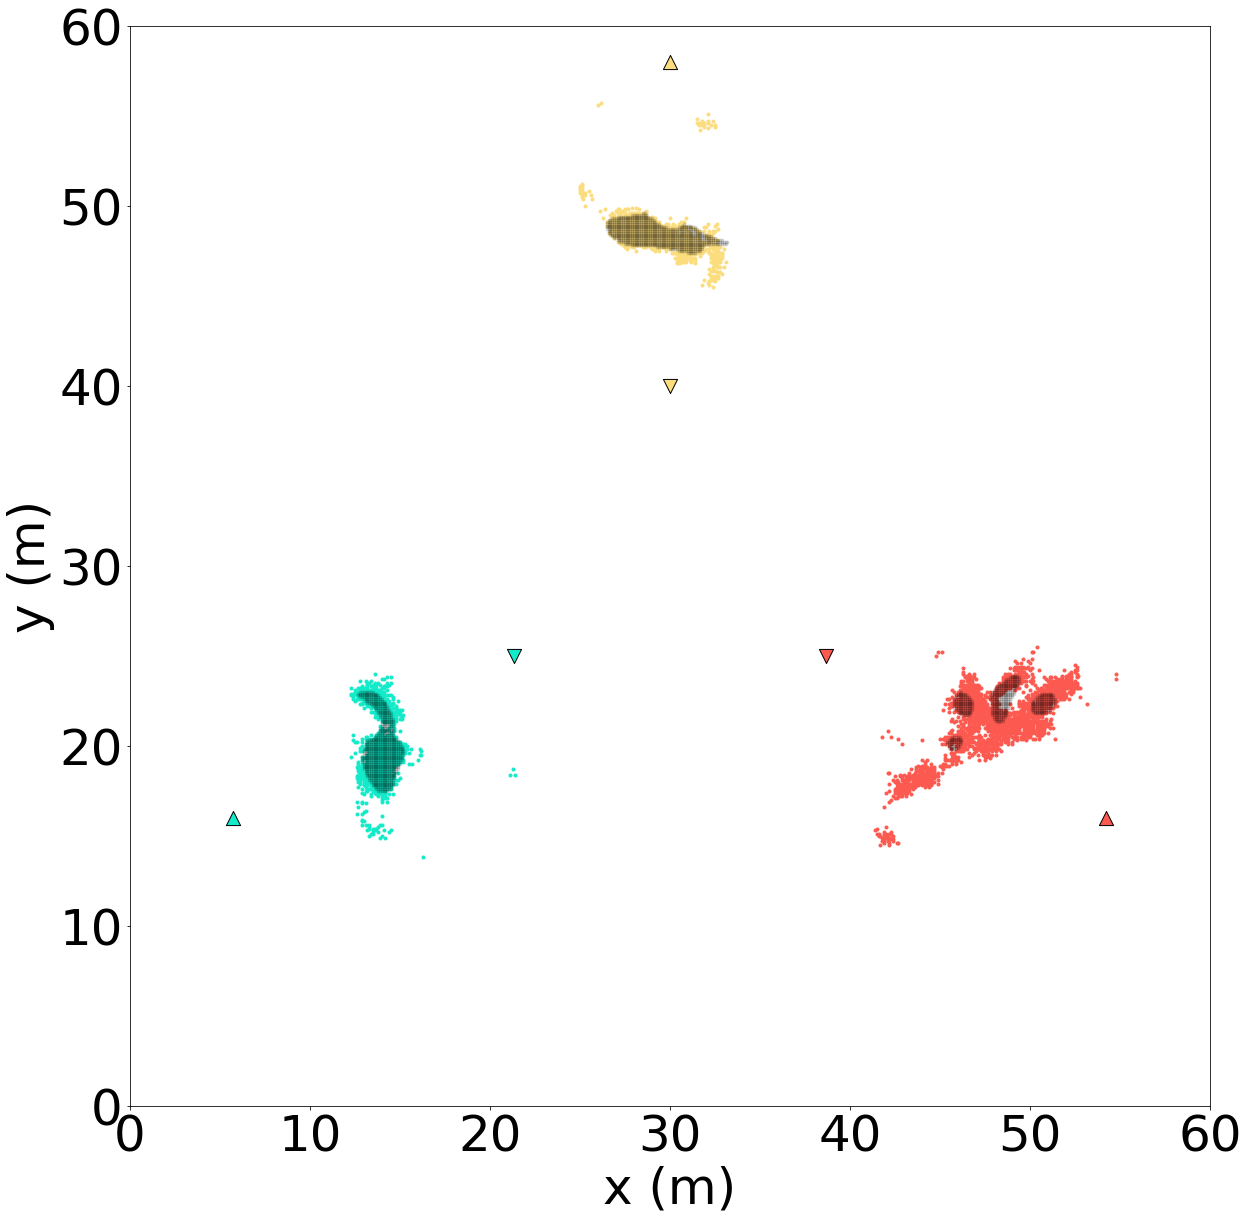

In [37]:
reload(sim)
sim.plotCFwithOverlay(n, tjcps, pjcps, qBase, region)
plt.gca().invert_yaxis()
plt.show()

Extracted edges...
Polygons constructed, looking for holes...
Constructed 1 possibly non-convex polygons
5 total subregions
Total of 1 Permutations to Try
Working on Permutation (0, 1, 2)
Optimal Solution Improved to 90.62
Elapsed Time: 0.20
Finding AORP
Found AORP
Subplot 0, 0
[[0.         0.49422838 0.50577162]
 [0.15710918 0.         0.84289082]
 [0.16019082 0.83980918 0.        ]]
Finding AORP
Found AORP
Subplot 0, 1
[[0.         0.48640145 0.51359855]
 [0.46951639 0.         0.53048361]
 [0.4830869  0.5169131  0.        ]]
Subplot 0, 1
[[0.         0.48640145 0.51359855]
 [0.46951639 0.         0.53048361]
 [0.4830869  0.5169131  0.        ]]
Finding AORP
Found AORP
Subplot 0, 2
[[0.         0.4810405  0.5189595 ]
 [0.93108383 0.         0.06891617]
 [0.93579605 0.06420395 0.        ]]
Extracted edges...
Polygons constructed, looking for holes...
Constructed 1 possibly non-convex polygons
5 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 

/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Found AORP
Finding AORP
Found AORP
Subplot 2, 1
[[0.         0.49526397 0.50473603]
 [0.26729735 0.         0.73270265]
 [0.27102397 0.72897603 0.        ]]
Finding AORP


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Found AORP
Extracted edges...
Polygons constructed, looking for holes...
Constructed 1 possibly non-convex polygons
5 total subregions
 &  0.08 & 77.30 & 0.14 &  0.80 & 60.33 & 0.43 &  0.80 & 59.07 & 0.43 & 47.16\\ 
 \hline 
 &  0.80 & 77.30 & 0.32 &  0.80 & 60.33 & 0.33 &  0.80 & 59.07 & 0.34 & 62.45\\ 
 \hline 
 &  8.00 & 77.30 & 0.48 &  0.80 & 60.33 & 0.25 &  0.80 & 59.07 & 0.27 & 67.23\\ 
 \hline 
 &  0.08 & 77.30 & 0.09 &  0.80 & 60.33 & 0.46 &  0.80 & 59.07 & 0.45 & 61.03\\ 
 \hline 
 &  0.80 & 77.30 & 0.25 &  0.80 & 60.33 & 0.37 &  0.80 & 59.07 & 0.38 & 92.23\\ 
 \hline 
 &  8.00 & 77.30 & 0.42 &  0.80 & 60.33 & 0.28 &  0.80 & 59.07 & 0.29 & 111.85\\ 
 \hline 
 &  0.08 & 77.30 & 0.07 &  0.80 & 60.33 & 0.47 &  0.80 & 59.07 & 0.47 & 74.97\\ 
 \hline 
 &  0.80 & 77.30 & 0.21 &  0.80 & 60.33 & 0.39 &  0.80 & 59.07 & 0.39 & 121.35\\ 
 \hline 
 &  8.00 & 77.30 & 0.38 &  0.80 & 60.33 & 0.30 &  0.80 & 59.07 & 0.32 & 155.45\\ 
 \hline 



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


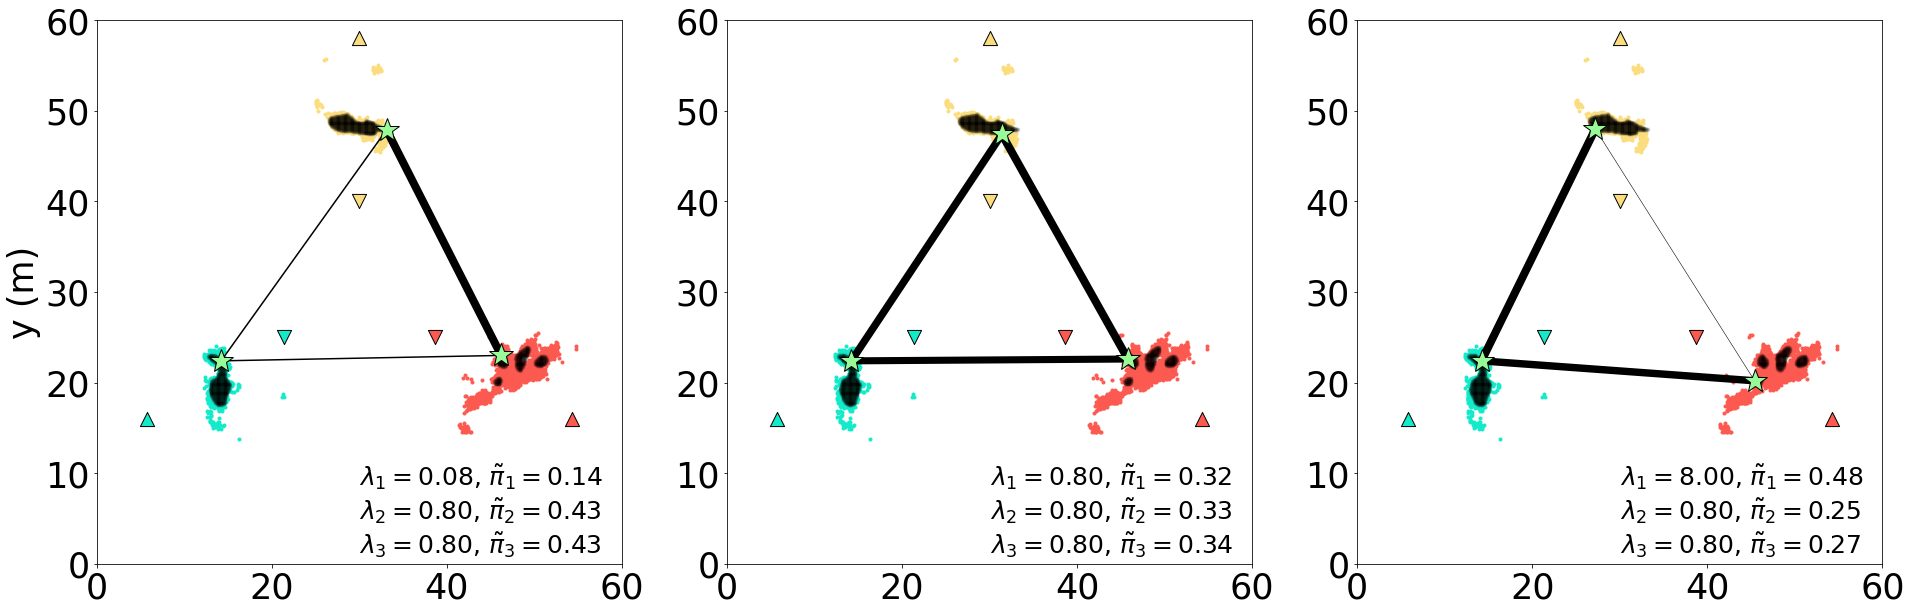

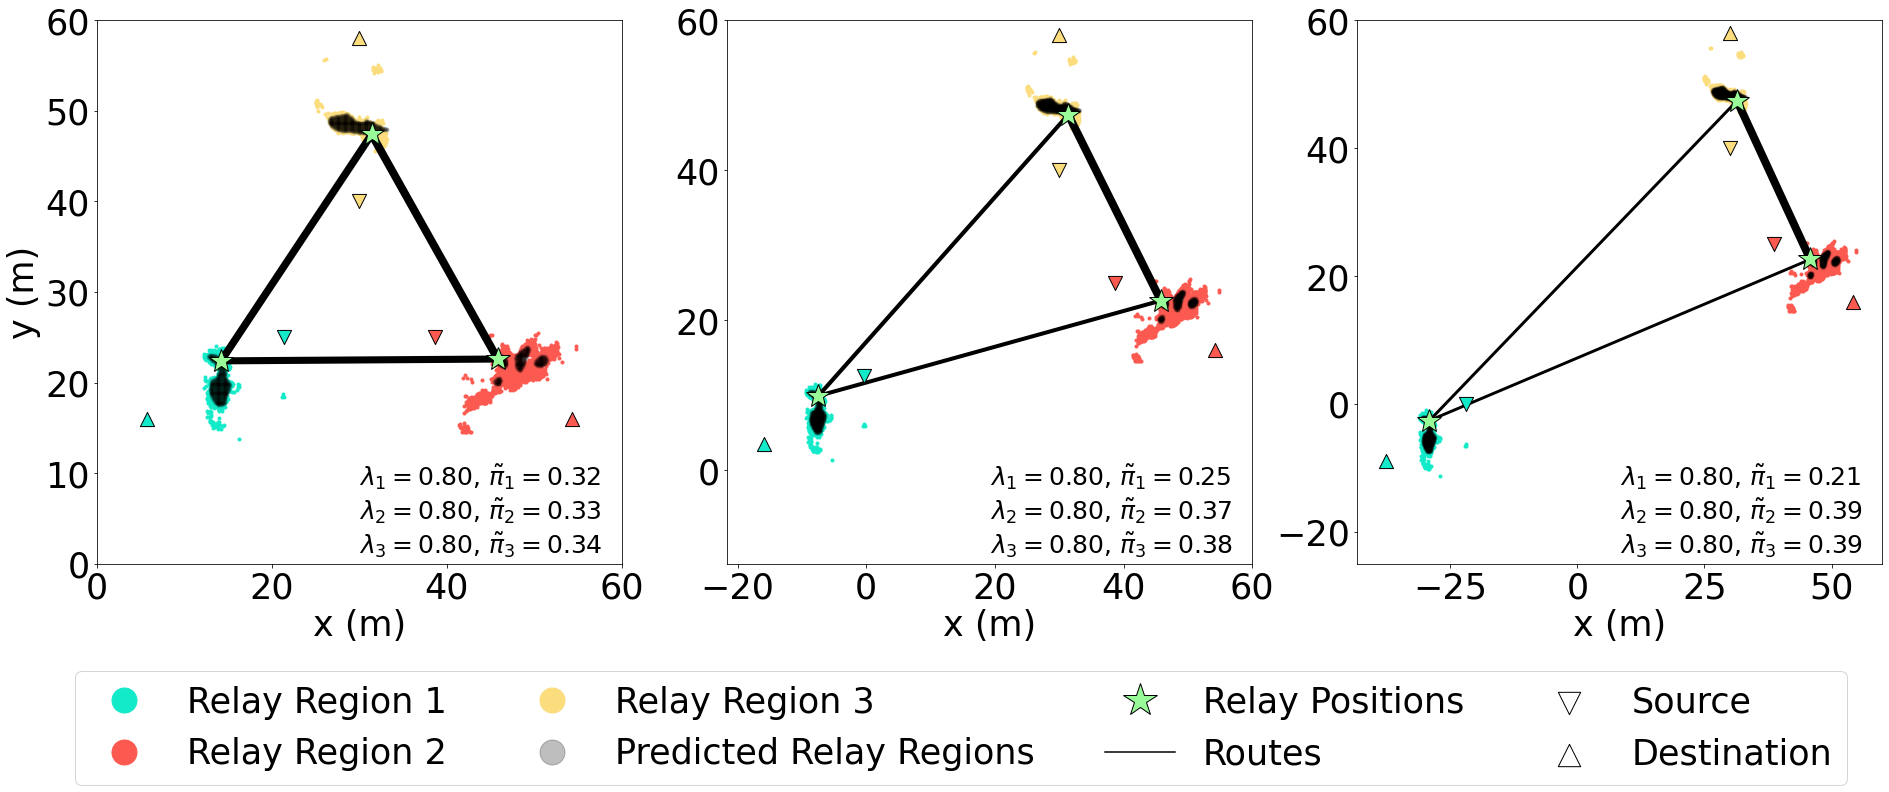

In [48]:
reload(dtr)
reload(TSPN)
reload(sim)
reload(PS)
#reload(MRP)
# dt_sys = dtr.DTR(pcs, region, els, beta, th = GAMMA_TH, p_th=p_th)
# ps = dt_sys.ps
v = 1
# dt_sys = dtr.DTR(pcs, region, els, beta, th = GAMMA_TH, p_th=p_th)
# ps = dt_sys.ps

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    'font.size': 35})

els = np.array([0.05, 0.05, 0.05])/beta
vals = np.array([0.005, 0.05, 0.5])/beta
Ws = []
W_cys = []
n_steps = 3
l = np.reshape(np.array([0,25,50]),(n_steps,1))
offsets = -1*l*np.array([np.cos(np.pi/6), np.sin(np.pi/6)])
regions = np.reshape(np.array([x_max, x_min, y_max, y_min]), (4,1)) + np.array([np.zeros(n_steps), offsets[:,0], np.zeros(n_steps), offsets[:,1]])
regions = regions.T


latex_table_str = ''

#figA, (axA1, axA2, axA3) = plt.subplots(1,3, figsize=(32, 16))
figA, axsA = plt.subplots(1,3, figsize=(32, 10))
figB, axsB = plt.subplots(1,3, figsize=(32, 10))
positions = ["Near", "Middle", "Far"]
rates = ['Low', "Equal", "High"]
k = 0
for offset, tregion in zip(offsets, regions):
    dt_sys.shiftRegion(0, offset)
    dt_sys.region = tregion
    tjcps[0] += offset
    pjcps[0] += offset
    qBase[0] += offset
    qBase[1] += offset
    #find the TSPNP
    sys_regions = dt_sys.cregions
    tspn_min, tspn_argmin = TSPN.TSPN_BF(sys_regions)
    TSPNP={'X':tspn_argmin[0], 'SEQ':tspn_argmin[1]}
    S_cy = dtr.XtoS(TSPNP['X'])
    S_cyv = np.zeros(n)
    seq = TSPNP['SEQ']
    for i in range(n):
        S_cyv[i] = S_cy[seq[i], seq[(i+1)%n]]
    
    for j in range(len(vals)):
        val = vals[j]
        els[0] =  val
        ps.Ls = els
        print("Finding AORP")
        AORP = sim.calc_AORP(dt_sys, v)
        print("Found AORP")
        pi = AORP['pi']
        S = dtr.XtoS(AORP['X'])
        
        
        #S_i = S @ pi
        W_rnd = ps._calc_avg_wait_random(S, pi)
        W_cy = ps._calc_avg_wait_cyclic(S_cyv)
        Ws.append(W_rnd)
        W_cys.append(W_cy)
         
        #print(S)
        P_tilde, pi_tilde = sim.pi_to_P(pi)
#         print(P_tilde)
#         S_i = np.diag(P_tilde@S)
#         print(els)
#         print(pi)
#         print(pi_tilde)
#         print(S_i)
#         print(W_rnd)
#         print(W_cy)
        #plot across varying arrival rates when regions are ~ equidistant
        if k == 0:
            ax = axsA[j]
            sim.plot_relay_regions(n, tjcps, pjcps, els = None, pi = None, ax = ax)
            sim.plot_bs(qBase, ax)
            sim.set_lims(tregion, ax)
            sim.plot_AORP_routes(AORP, ax)
            ax.invert_yaxis()
            if j == 0:
                ax.set_ylabel('y (m)')
            #ax.set_title(positions[k]+', '+rates[j])
            
            label1 = '$\\lambda_%d = %.2f$, $\\tilde{\\pi}_%d = %.2f$'%(1, els[0], 1, pi_tilde[0])
            label2 = '$\\lambda_%d = %.2f$, $\\tilde{\\pi}_%d = %.2f$'%(2, els[1], 2, pi_tilde[1])
            label3 = '$\\lambda_%d = %.2f$, $\\tilde{\\pi}_%d = %.2f$'%(3, els[2], 3, pi_tilde[2])
            print("Subplot %d, %d"%(k,j))
            print(P_tilde)
            label = label1 +"\n" + label2 + "\n" + label3
            ax.annotate(label, xy=(0.5,0.02),xycoords='axes fraction',
             fontsize=25)
        #plot across varying distances when arrival rates are ~ equidistant
        if j == 1:
            ax = axsB[k]
            sim.plot_relay_regions(n, tjcps, pjcps, els = None, pi = None, ax = ax)
            sim.plot_bs(qBase, ax)
            sim.set_lims(tregion, ax)
            sim.plot_AORP_routes(AORP, ax)
            ax.invert_yaxis()
            if k == 0:
                ax.set_ylabel('y (m)')
            ax.set_xlabel('x (m)')
            #ax.set_title(positions[k]+', '+rates[j])
            label1 = '$\\lambda_%d = %.2f$, $\\tilde{\\pi}_%d = %.2f$'%(1, els[0], 1, pi_tilde[0])
            label2 = '$\\lambda_%d = %.2f$, $\\tilde{\\pi}_%d = %.2f$'%(2, els[1], 2, pi_tilde[1])
            label3 = '$\\lambda_%d = %.2f$, $\\tilde{\\pi}_%d = %.2f$'%(3, els[2], 3, pi_tilde[2])
            label = label1 +"\n" + label2 + "\n" + label3
            ax.annotate(label, xy=(0.5,0.02),xycoords='axes fraction',
             fontsize=25)
            print("Subplot %d, %d"%(k,j))
            print(P_tilde)
        
        latex_table_str += ' & '
        for i in range(n):   
            latex_table_str += " %.2f & %.2f & %.2f & "%(els[i], S_i[i], pi_tilde[i])
        latex_table_str += "%.2f\\\\ \n \\hline \n"%(W_rnd)
    dt_sys.shiftRegion(0, -offset)#move back
    tjcps[0] -= offset
    pjcps[0] -= offset
    qBase[0] -= offset
    qBase[1] -= offset
    k += 1
print(latex_table_str)

handles, labels = axsB[2].get_legend_handles_labels()
figB.legend(handles, labels, loc='upper center', bbox_to_anchor=[0.5,0.00], ncol=4)

figA.savefig('fig3_variation_over_lambda.eps', format='eps', bbox_inches='tight')
figB.savefig('fig3_variation_over_position.eps', format='eps', bbox_inches='tight')
figA.savefig('fig3_variation_over_lambda.png', format='png', bbox_inches='tight')
figB.savefig('fig3_variation_over_position.png', format='png', bbox_inches='tight')

In [54]:
#plot vs offset
import cplex_solvers as CPLX

reload(CPLX)
reload(dtr)
reload(TSPN)
reload(sim)
reload(PS)
#reload(MRP)
v = 1

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    'font.size': 35})

base = 0.05/beta
els = base*np.ones(3)
Ws = []
W_cys = []
l = np.arange(0,60,10)
n_steps = len(l)
l = np.reshape(l,(n_steps,1))

offsets = -1*l*np.array([np.cos(np.pi/6), np.sin(np.pi/6)])
regions = np.reshape(np.array([x_max, x_min, y_max, y_min]), (4,1)) + np.array([np.zeros(n_steps), offsets[:,0], np.zeros(n_steps), offsets[:,1]])
regions = regions.T


scale = np.arange(0.5, 2.25, 0.25)
n_vals = len(scale)
# dt_sys = dtr.DTR(pcs, region, els, beta, th = GAMMA_TH, p_th=p_th)
# ps = dt_sys.ps

pi1s = np.zeros((n_steps, n_vals))
pi1s_obs = np.zeros((n_steps, n_vals))
pis = np.zeros((n_steps, n_vals, 3))

all_Xs = []
Ws = np.zeros((n_steps, n_vals))
# for offset, tregion in zip(offsets, regions):
for i in range(n_steps):
    offset = offsets[i]
    tregion = regions[i]
    dt_sys.shiftRegion(0, offset)
    dt_sys.region = tregion

    offset_Xs = []
    for j in range(n_vals):
        print("Iteration %d, %d"%(i,j))
        c = scale[j]
        els[0] =  c*base
        ps.Ls = els

        AORP = sim.calc_AORP(dt_sys, v)
        pi = AORP['pi']
        offset_Xs.append(AORP['X'])
        pis[i,j] = pi
        S = dtr.XtoS(AORP['X'])
        #normalize
        #get observed
        P, pi_obs = sim.pi_to_P(pi)
        pi1s_obs[i,j] = pi_obs[0]
        pi1s[i,j] = pi[0]
        w_cur = ps._calc_avg_wait_random(S, pi)
        Ws[i,j] = w_cur
        if j>0:
            #check to see if we need to do some smoothing
            
            #maybe the current one is just low, so try a couple things
            if pi1s[i,j]<pi1s[i, j-1]:
                #Check double check that we're optimal at this scale value
                AORP = sim.calc_AORP(dt_sys, v)
                pi = AORP['pi']
                S = dtr.XtoS(AORP['X'])
                
                w_cur_new = ps._calc_avg_wait_random(S, pi)
                if w_cur_new <=w_cur:
                    Ws[i,j] = w_cur_new
                    #then this is truly more optimal, and we should use it
                    pis[i,j] = pi
                    P, pi_obs = sim.pi_to_P(pi)
                    offset_Xs[-1] = AORP['X']
                    #did it increase pi[0]?
                    if pi1s[i,j] < pi[0]:
                        print("Increased pi[0] from %.4f to %.4f"%(pi1s[i,j], pi[0]))
                    #regardless, this was a beter outcome
                    pi1s[i,j] = pi[0]
                    pi1s_obs[i,j] = pi_obs[0]
                    
                #Also check to see if using a smarter start helps
                AORP = sim.calc_AORP(dt_sys, v, X0 = offset_Xs[-2])
                pi = AORP['pi']
                S = dtr.XtoS(AORP['X'])
                w_cur_new = ps._calc_avg_wait_random(S, pi)
                if w_cur_new <=w_cur:
                    Ws[i,j] = w_cur_new
                    #then this is truly more optimal, and we should use it
                    pis[i,j] = pi
                    P, pi_obs = sim.pi_to_P(pi)
                    offset_Xs[-1] = AORP['X']
                    #did it increase pi[0]?
                    if pi1s[i,j] < pi[0]:
                        print("Increased pi[0] from %.4f to %.4f"%(pi1s[i,j], pi[0]))
                    #regardless, this was a beter outcome
                    pi1s[i,j] = pi[0]
                    pi1s_obs[i,j] = pi_obs[0]
                    
                #also check that we weren't just super high last time
                c = scale[j-1]
                els[0] =  c*base
                ps.Ls = els
    
                AORP = sim.calc_AORP(dt_sys, v)
                pi = AORP['pi']
                S = dtr.XtoS(AORP['X'])
                
                w_cur_new = ps._calc_avg_wait_random(S, pi)
                if w_cur_new <=w_cur:
                    #then this is truly more optimal, and we should use it
                    pis[i,j-1] = pi
                    P, pi_obs = sim.pi_to_P(pi)
                    offset_Xs[-2] = AORP['X']
                    #did it increase pi[0]?
                    if pi1s[i,j-1] < pi[0]:
                        print("Increased pi[0] from %.4f to %.4f"%(pi1s[i,j-1], pi[0]))
                    #regardless, this was a beter outcome
                    pi1s[i,j-1] = pi[0]
                    pi1s_obs[i,j-1] = pi_obs[0]
                    
                #Also check to see if using a smarter start helps
                if j>1:
                    AORP = sim.calc_AORP(dt_sys, v, X0 = offset_Xs[-3])
                    pi = AORP['pi']
                    S = dtr.XtoS(AORP['X'])
                    w_cur_new = ps._calc_avg_wait_random(S, pi)
                    if w_cur_new <=w_cur:
                         #then this is truly more optimal, and we should use it
                        pis[i,j-1] = pi
                        P, pi_obs = sim.pi_to_P(pi)
                        offset_Xs[-2] = AORP['X']
                        #did it increase pi[0]?
                        if pi1s[i,j-1] < pi[0]:
                            print("Increased pi[0] from %.4f to %.4f"%(pi1s[i,j-1], pi[0]))
                        #regardless, this was a beter outcome
                        pi1s[i,j-1] = pi[0]
                        pi1s_obs[i,j-1] = pi_obs[0]

                c = scale[j]
                els[0] =  c*base
                ps.Ls = els
                
            if pi1s[i,j]<pi1s[i, j-1]:#if it's still not better, print out some useful info
                print("weird spike detected")
                print("params", offset, c)
                print("Previous pi", pis[i, j-1])
                print("Current pi", pis[i, j])
                print("pi[0] should increase")
                print("Previous positions: ", offset_Xs[-2])
                print("Previous dists: ", dtr.XtoS(offset_Xs[-2]))
                print("Current positions: ", offset_Xs[-1])
                print("Current dists: ", dtr.XtoS(offset_Xs[-1]))
                print("Diff caused by shift?")
                
                print("can we do better using some of the past results?")
                S_prev = dtr.XtoS(offset_Xs[-2])
                W_rnd = ps._calc_avg_wait_random(S, pi)
                print("Current Wait Time: %.4f"%(W_rnd))
                #try with previous pi
                W_rnd = ps._calc_avg_wait_random(S, pis[i, j-1])
                print("Wait Time with prev pi: %.4f"%(W_rnd))
                #try with previous S
                print("Wait time with previous S: %.4f"%(W_rnd))
                W_rnd = ps._calc_avg_wait_random(S_prev, pi)
                #try with previous pi and S
                print("Wait time with previous S and pi: %.4f"%(W_rnd))
                W_rnd = ps._calc_avg_wait_random(S_prev, pis[i, j-1])
                
                #conjecture - it's due to initizliation, so we can try to
                #1 try again
                AORP = sim.calc_AORP(dt_sys, v)
                print("Recalc'd AORP", AORP)
                #2 also look at the old scenario again - perhaps it was too high
                c = scale[j-1]
                els[0] =  c*base
                ps.Ls = els
                AORP = sim.calc_AORP(dt_sys, v)
                print("Recalc'd prev AORP", AORP)
                
                #revert back
                c = scale[j]
                els[0] =  c*base
                ps.Ls = els
                #3 try inching up the probabilites using the previous location
                pi_test = pis[i, j-1]
                for k in range(20):
                    pi_test += np.array([0.005, -.0025, -.0025])
                    W_rnd = ps._calc_avg_wait_random(S_prev, pi_test)
                    print("Wait Time with more granular pi, old positions: %.4f"%(W_rnd), pi_test)
#                 print("oops, lets try that again!")
#                 AORP = sim.calc_AORP(dt_sys, v)
#                 pi = AORP['pi']
#                 offset_Xs[-1]= AORP['X']
#                 pis[i,j] = pi
#                 S = dtr.XtoS(AORP['X'])
#                 #normalize
#                 #get observed
#                 P, pi_obs = sim.pi_to_P(pi)
#                 #pi1s[i,j] = pi_obs[0]
#                 pi1s[i,j] = pi[0]
#                 print(pi_obs[0])

    dt_sys.shiftRegion(0, -offset)#move back
    all_Xs.append(offset_Xs)

Extracted edges...
Polygons constructed, looking for holes...
Constructed 1 possibly non-convex polygons
5 total subregions
Iteration 0, 0
Iteration 0, 1
Iteration 0, 2
Iteration 0, 3
Iteration 0, 4
Iteration 0, 5
Iteration 0, 6
Extracted edges...
Polygons constructed, looking for holes...
Constructed 1 possibly non-convex polygons
5 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 1 possibly non-convex polygons
5 total subregions
Iteration 1, 0


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 1, 1
Iteration 1, 2
Iteration 1, 3
Iteration 1, 4
Iteration 1, 5
Iteration 1, 6
Extracted edges...
Polygons constructed, looking for holes...
Constructed 1 possibly non-convex polygons
5 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 1 possibly non-convex polygons
5 total subregions
Iteration 2, 0


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 2, 1
Iteration 2, 2
Iteration 2, 3
Iteration 2, 4
Iteration 2, 5
Iteration 2, 6
Extracted edges...
Polygons constructed, looking for holes...
Constructed 1 possibly non-convex polygons
5 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 1 possibly non-convex polygons
5 total subregions
Iteration 3, 0


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 3, 1


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 3, 2
Iteration 3, 3
Iteration 3, 4
Iteration 3, 5
Iteration 3, 6
Extracted edges...
Polygons constructed, looking for holes...
Constructed 1 possibly non-convex polygons
5 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 1 possibly non-convex polygons
6 total subregions
Iteration 4, 0
Iteration 4, 1
Iteration 4, 2
Iteration 4, 3
Iteration 4, 4
Iteration 4, 5
Iteration 4, 6
Extracted edges...
Polygons constructed, looking for holes...
Constructed 1 possibly non-convex polygons
5 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 1 possibly non-convex polygons
6 total subregions
Iteration 5, 0


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 5, 1
Iteration 5, 2
Iteration 5, 3
Iteration 5, 4
Iteration 5, 5
Iteration 5, 6
Extracted edges...
Polygons constructed, looking for holes...
Constructed 1 possibly non-convex polygons
5 total subregions


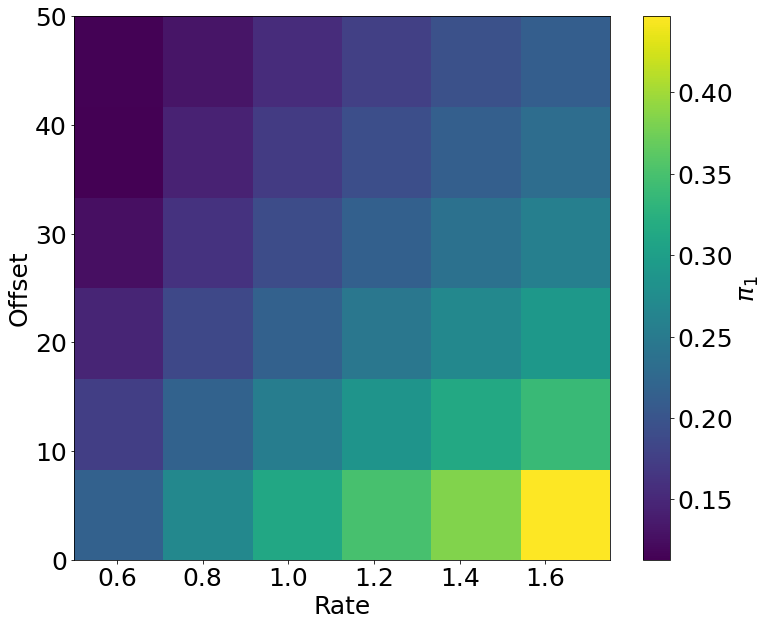

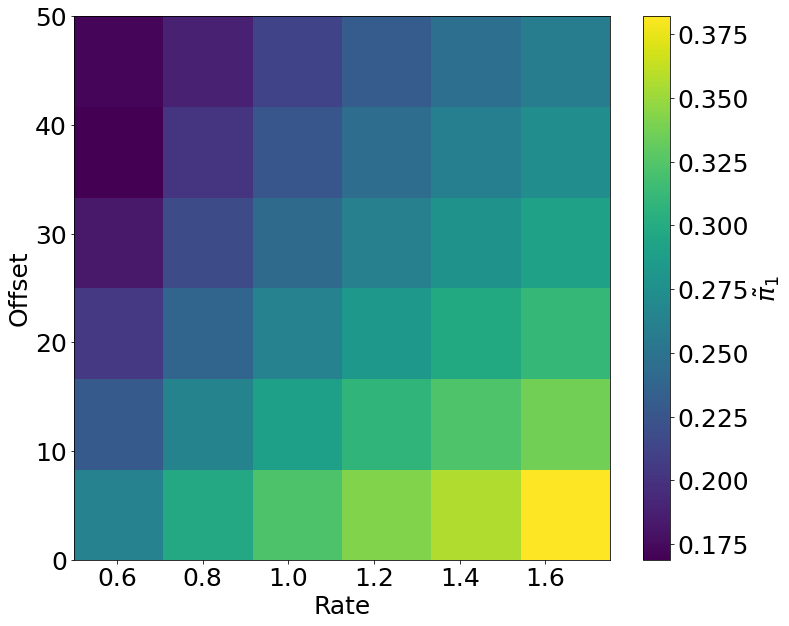

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


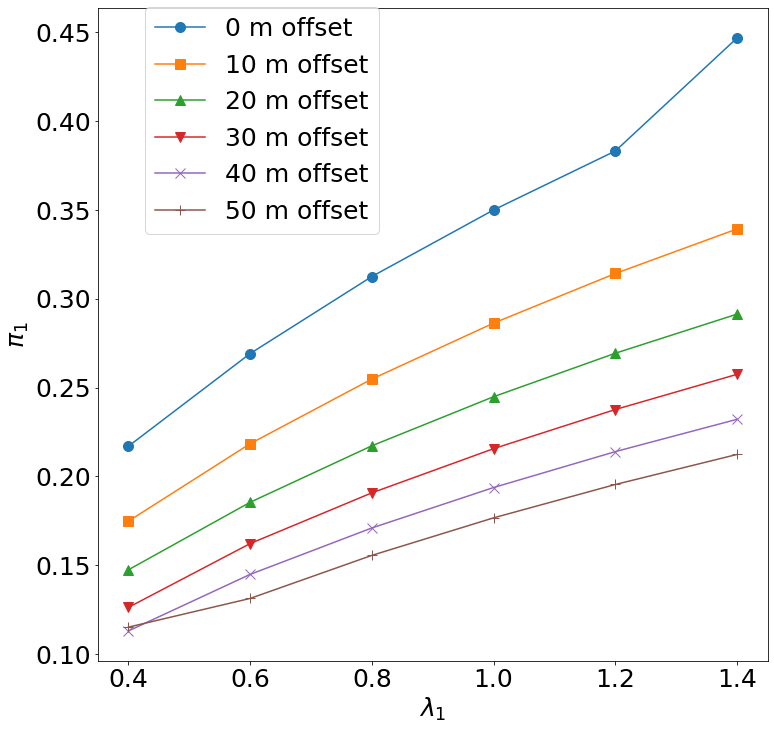

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


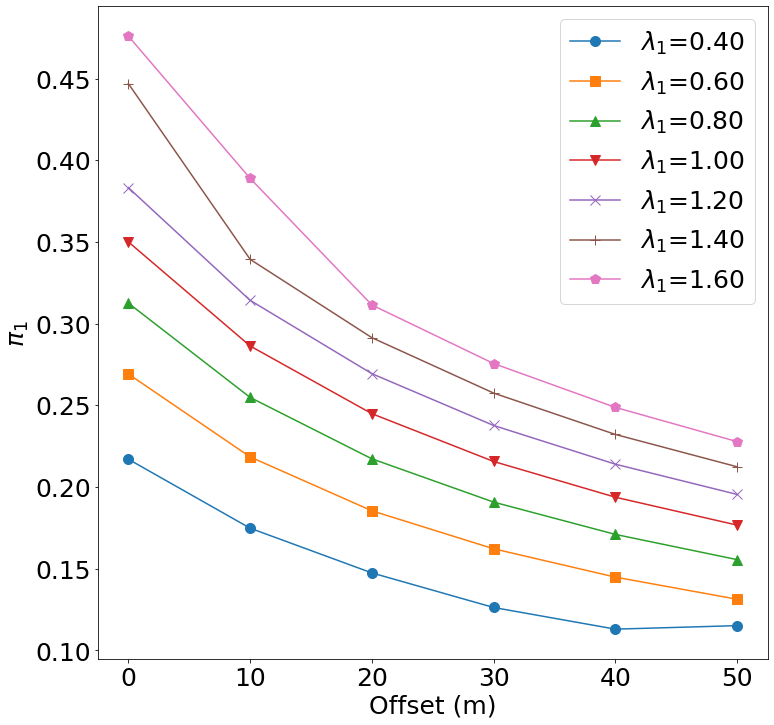

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


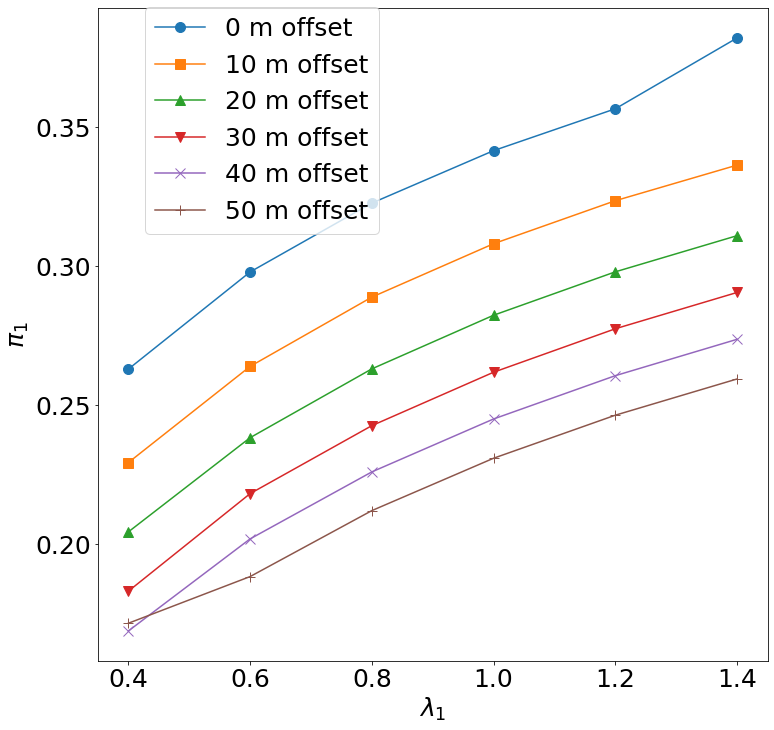

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


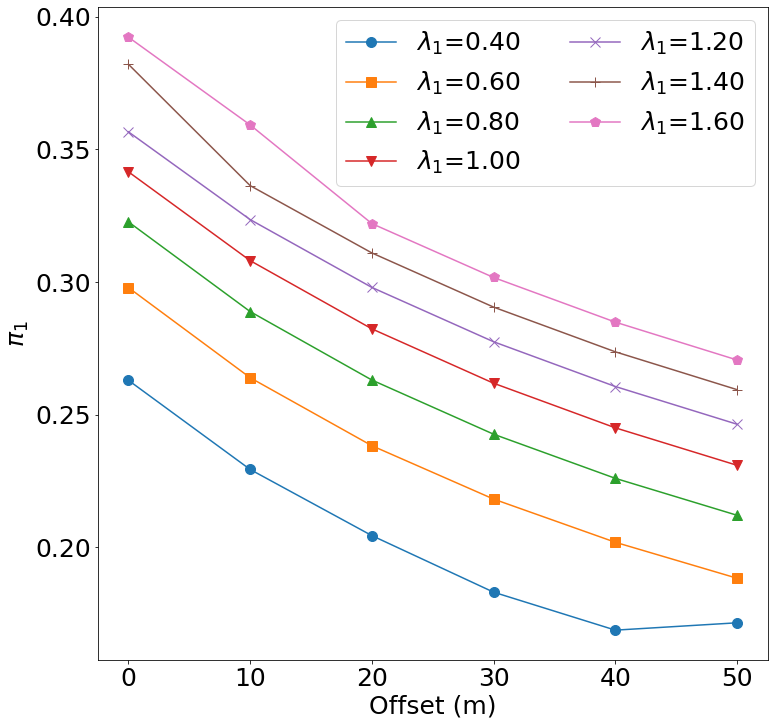

In [66]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    "font.size": 25
    })

fig = plt.figure(figsize =(12,10))
im = plt.imshow(pi1s[:,:-1], origin = "lower", extent=[ scale[0], scale[-2], l[0,0], l[-1,0]], aspect = 'auto')
cb = fig.colorbar(im, label="$\\pi_1$")
plt.xlabel("Rate")
plt.ylabel("Offset")
# plt.title("Effect of Arrival Rates and Distance on AORP Visit Frequency")
plt.show()

fig = plt.figure(figsize =(12,10))
cb = plt.imshow(pi1s_obs[:,:-1], origin = "lower", extent=[ scale[0], scale[-2], l[0,0], l[-1,0]], aspect = 'auto')
fig.colorbar(cb, label = "$\\tilde{\\pi}_1$")
plt.xlabel("Rate")
plt.ylabel("Offset")
# plt.title("Effect of Arrival Rates and Distance on Observed Visit Frequency")
plt.show()




markers = ["o", "s", "^", "v", "x", "+", "p", "P"]
ms = 10

fig = plt.figure(figsize =(12,12))
for i in range(n_steps):
    plt.plot(scale[:-1]*base, pi1s[i,:-1], "-"+markers[i], markersize=ms, label="%d m offset"%(l[i]))
plt.ylabel("$\\pi_1$")
plt.xlabel("$\\lambda_1$")
plt.legend(loc="upper center", bbox_to_anchor=[0.245,1.021])
# plt.title("AORP Visit Frequency vs $\\lambda_1$")
plt.savefig('fig4_pi1_v_lambda.png', format='png', bbox_inches='tight')
plt.savefig('fig4_pi1_v_lambda.eps', format='eps', bbox_inches='tight')
plt.show()


fig = plt.figure(figsize =(12,12))
for j in range(n_vals):
    plt.plot(l, pi1s[:,j], "-"+markers[j], markersize=ms, label="$\\lambda_1$=%.2f"%(scale[j]*base))   
plt.ylabel("$\\pi_1$")
plt.xlabel("Offset (m)")
plt.legend(loc="upper right")#, bbox_to_anchor=[1,0.9])
# plt.title("AORP Visit Frequency vs Offset")
plt.savefig('fig4_pi1_v_offset.png', format='png', bbox_inches='tight')
plt.savefig('fig4_pi1_v_offset.eps', format='eps', bbox_inches='tight')
plt.show()



fig = plt.figure(figsize =(12,12))
for i in range(n_steps):
    plt.plot(scale[:-1]*base, pi1s_obs[i,:-1], "-"+markers[i], markersize=ms, label="%d m offset"%(l[i]))
plt.ylabel("$\\pi_1$")
plt.xlabel("$\\lambda_1$")
plt.legend(loc="upper center", bbox_to_anchor=[0.245,1.021])
# plt.title("AORP Visit Frequency vs $\\lambda_1$")
plt.savefig('fig4_pi1obs_v_lambda.png', format='png', bbox_inches='tight')
plt.savefig('fig4_pi1obs_v_lambda.eps', format='eps', bbox_inches='tight')
plt.show()


fig = plt.figure(figsize =(12,12))
for j in range(n_vals):
    plt.plot(l, pi1s_obs[:,j], "-"+markers[j], markersize=ms, label="$\\lambda_1$=%.2f"%(scale[j]*base))   
plt.ylabel("$\\pi_1$")
plt.xlabel("Offset (m)")
plt.legend(loc="upper right", ncol=2)#, bbox_to_anchor=[1,0.9])
# plt.title("AORP Visit Frequency vs Offset")
plt.savefig('fig4_pi1obs_v_offset.png', format='png', bbox_inches='tight')
plt.savefig('fig4_pi1obs_v_offset.eps', format='eps', bbox_inches='tight')
plt.show()



# fig, (ax1, ax2) = plt.subplots(1,2,figsize =(36,16))
# idces = [0, 5, 10]
# for i in range(3):
#     ax1.plot(scale[:-1]*base, pi1s[idces[i],:-1], "-"+markers[i], markersize=ms, label="%d m offset"%(l[idces[i]]))
# ax1.set_ylabel("$\\tilde{\\pi}_1$")
# ax1.set_xlabel("$\\lambda_1$")
# ax1.legend(loc="upper center", bbox_to_anchor=[0.25,1.021], frameon=False)
# # ax1.legend(loc="upper left",frameon=False)
# # plt.title("Observed Visit Frequency vs $\\lambda_1$")
# # plt.savefig('fig4_pi1obs_v_lambda.png', format='png', bbox_inches='tight')
# # plt.savefig('fig4_pi1obs_v_lambda.eps', format='eps', bbox_inches='tight')
# # plt.show()

# idces = [0, -1, -2]
# #fig = plt.figure(figsize =(12,12))
# for j in range(3):
#     ax2.plot(l, pi1s_obs[:,idces[j]], "-"+markers[j], markersize=ms, label="$\\lambda_1$=%.2f"%(scale[idces[j]]))
# ax2.set_ylabel("$\\tilde{\\pi}_1$")
# ax2.set_xlabel("Offset (m)")
# ax2.legend(frameon = False)
# #plt.title("Observed Visit Frequency vs Offset")
# # plt.savefig('fig4_pi1obs_v_offset.png', format='png', bbox_inches='tight')
# # plt.savefig('fig4_pi1obs_v_offset.eps', format='eps', bbox_inches='tight')
# # plt.show()


# fig.savefig('fig4_pi1obs_v_offset_and_lambda.png', format='png', bbox_inches='tight')
# fig.savefig('fig4_pi1obs_v_offset_and_lambda.eps', format='eps', bbox_inches='tight')


In [56]:
scale

array([0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  ])

In [51]:
np.arange(0.5, 2.25, 0.25)

array([0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  ])

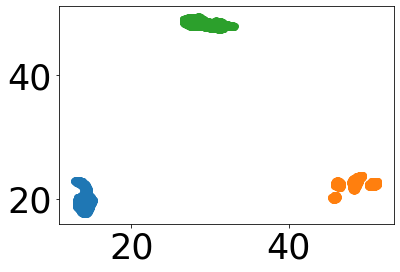

In [49]:
for Xi in dt_sys.Xis:
    pts = Xi['points']
    plt.scatter(pts[:,0], pts[:,1])